In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import data_transformation
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv(r'C:\Priyanka\job_application_2024\JPMorganChase\Take Home Project\training_loan_data.csv', header=1)
data.head(5)

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,...,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,10000001,11983056.0,7550,36 months,16.24%,3 years,RENT,28000.0,NaN,debt_consolidation,...,0.0,17.0,72%,4000.0,NaN,3828.953801,5759.0,1,99,0.0
1,10000002,12002921.0,27050,36 months,10.99%,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,...,0.0,8.0,61.20%,35700.0,NaN,34359.940730,114834.0,1,353,0.0
2,10000003,11983096.0,12000,36 months,10.99%,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,...,1.0,3.0,24%,18100.0,NaN,16416.617760,7137.0,1,157,0.0
3,10000004,12003142.0,28000,36 months,7.62%,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,...,1.0,3.0,54.60%,42200.0,NaN,38014.149760,799592.0,1,365,0.0
4,10000005,11993233.0,12000,36 months,13.53%,10+ years,RENT,40000.0,NaN,debt_consolidation,...,0.0,17.0,68.80%,7000.0,53.0,6471.462236,13605.0,1,157,0.0


### Data Preparation
- remove duplicates
- split data into train and test set

In [3]:
data.drop_duplicates(keep='first', inplace=True)
data.reset_index(drop=True, inplace=True)
data.dropna(subset=['bad_flag'], inplace=True)

In [151]:
len(data)

188123

In [4]:
# split into train and test set
## Separating Independent and Dependent Columns
X = data.drop(['bad_flag'],axis=1)
Y = data[['bad_flag']]

# Splitting the dataset into the Training and Testing set.
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1)


In [298]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188123 entries, 0 to 188122
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           188123 non-null  int64  
 1   member_id                    188123 non-null  float64
 2   loan_amnt                    188123 non-null  int64  
 3   term                         188123 non-null  object 
 4   int_rate                     188123 non-null  object 
 5   emp_length                   180246 non-null  object 
 6   home_ownership               188123 non-null  object 
 7   annual_inc                   188123 non-null  float64
 8   desc                         81461 non-null   object 
 9   purpose                      188123 non-null  object 
 10  percent_bc_gt_75             179096 non-null  float64
 11  bc_util                      179012 non-null  float64
 12  dti                          188123 non-null  float64
 13  inq_

In [5]:
pipeline = data_transformation.init_pipeline()

In [6]:
x_train = data_transformation.preprocessor(x_train)
x_train = pipeline.fit_transform(x_train)


In [7]:
x_test = data_transformation.preprocessor(x_test)
x_test = pipeline.transform(x_test)

In [233]:
len(x_train), len(x_test)

(150498, 37625)

### Apply oversampling technique - SMOTE to balance the training set. 
I did not oversample  the entire set, because I wanted to testing set to be original data for model validation.

In [8]:
smote=SMOTE(sampling_strategy='not majority')
x_sm , y_sm = smote.fit_resample(x_train,y_train)

In [9]:
print("After Oversampling - SMOTE, the shape of x_train: {}".format(x_sm.shape))
print("After Oversampling - SMOTE, the shape of y_train: {} \n".format(y_sm.shape))

After Oversampling - SMOTE, the shape of x_train: (279996, 24)
After Oversampling - SMOTE, the shape of y_train: (279996, 1) 



In [236]:
x_sm

array([[ 0.0047241 ,  0.67568597,  0.46723384, ...,  0.        ,
         0.        ,  0.        ],
       [-0.29115765,  0.23351821, -0.61049966, ...,  0.        ,
         0.        ,  0.        ],
       [-0.67642035,  1.00956775, -0.57268445, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.96598322,  0.13409657, -0.2420328 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.54437578,  1.97982126,  0.91687286, ...,  0.        ,
         0.        ,  0.        ],
       [-1.1898345 , -0.37387825,  0.05702376, ...,  0.        ,
         0.        ,  0.        ]])

### Model Training

In [10]:
# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_neurons, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_neurons)  # Hidden layer
        self.output = nn.Linear(hidden_neurons, output_size)  # Output layer
        self.activation = nn.ReLU()  # Activation function for hidden layer
        self.sigmoid = nn.Sigmoid()  # Activation function for output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        x = self.sigmoid(x)  # Output layer for binary classification
        return x

# Training function
def train_model(model, x_train_tensor, y_train_tensor, criterion, optimizer, epochs=20):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        epoch_loss = 0
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(x_train_tensor)  # Forward pass
        loss = criterion(outputs.squeeze(), y_train_tensor.squeeze())  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        epoch_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(x_train_tensor):.4f}")
    

# Inference function
def inference(model, x_test_tensor, y_test_tensor):
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():
        outputs = model(x_test_tensor)  # Forward pass
        val_loss = criterion(outputs.squeeze(), y_test_tensor.squeeze())
        print(f"Value Loss: {val_loss.item()}")
        predicted = (outputs.squeeze() > 0.5).float()  # Binary classification threshold
        predictions.extend(predicted.tolist())
    return predictions

# Example Workflow
if __name__ == "__main__":
    # Convert data to PyTorch tensors
    
    x_train_tensor = torch.tensor(x_sm, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_sm.to_numpy(), dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    print(x_train_tensor)
    # Define model, loss function, and optimizer
    input_size = x_train.shape[1]
    hidden_neurons = 8  # Configurable hidden layer size
    output_size = 1  # Single output for binary classification

    model = NeuralNetwork(input_size, hidden_neurons, output_size)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.1)

    # Train the model
    print("Training the model...")
    train_model(model, x_train_tensor, y_train_tensor, criterion, optimizer, epochs=10)
    print(summary(model, input_size=(input_size,)))
    # Perform inference
    print("\nPerforming inference on test dataset...")
    
    predictions = inference(model, x_test_tensor, y_test_tensor)

    # Output predictions
    print("Predictions:", len(predictions))

tensor([[ 0.0047,  0.6757,  0.4672,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2912,  0.2335, -0.6105,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6764,  1.0096, -0.5727,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.4337,  1.9216,  0.3868,  ...,  0.0000,  0.0000,  0.0000],
        [-1.0156,  0.2040, -0.5762,  ...,  0.0000,  0.0000,  0.0000],
        [-1.0461, -0.6988, -0.4010,  ...,  0.0000,  0.0000,  0.0000]])
Training the model...
Epoch [1/10], Loss: 0.0000
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]             200
              ReLU-2                    [-1, 8]               0
            Line

In [11]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_and_report(y_pred, y_test, threshold):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    features: independent variables
    target: dependent variable
    threshold: threshold for the prediction
    """
    #y_pred = model.predict(features)
    #y_pred = (y_pred > threshold)
    
    cm = confusion_matrix(y_test_tensor.squeeze(), y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


    #Accuracy as per the classification report 
    print("\nClassification Report:\n")
    cr=classification_report(y_test_tensor.squeeze(),y_pred)
    print(cr)


Classification Report:

              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     34997
         1.0       0.11      0.65      0.18      2628

    accuracy                           0.60     37625
   macro avg       0.53      0.62      0.46     37625
weighted avg       0.90      0.60      0.70     37625



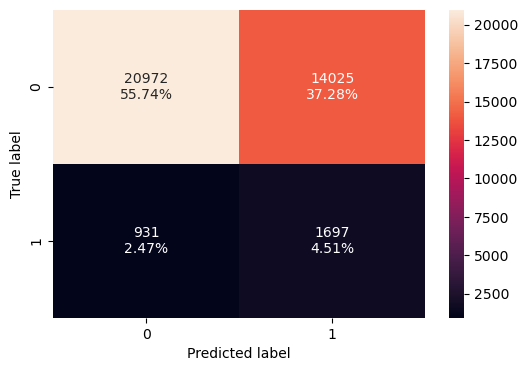

In [12]:
confusion_matrix_and_report(predictions, y_test_tensor, 0.5)

In [13]:
print("f1_score: {}".format(f1_score(y_test_tensor.squeeze(), predictions)))
print("precision_score: {}".format(precision_score(y_test_tensor.squeeze(), predictions)))
print("recall_score: {}".format(recall_score(y_test_tensor.squeeze(), predictions)))

f1_score: 0.1849591280653951
precision_score: 0.10793792138404783
recall_score: 0.645738203957382


In [14]:
#read the testing data
test_data = pd.read_csv(r'C:\Priyanka\job_application_2024\JPMorganChase\Take Home Project\testing_loan_data.csv')
test_data.head(5)

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,...,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,20000001,22419852,10000,36 months,22.15%,8 years,RENT,37000.0,NaN,debt_consolidation,...,1,3.0,73.10%,16200,NaN,14877.170280,36809,1,131,NaN
1,20000002,22349118,1400,36 months,18.24%,6 years,RENT,41000.0,NaN,other,...,0,9.0,11.50%,4000,NaN,4097.304770,19536,1,19,NaN
2,20000003,22398818,7000,36 months,12.49%,3 years,RENT,68900.0,NaN,debt_consolidation,...,0,11.0,48.10%,11900,80.0,12688.495160,241465,1,92,NaN
3,20000004,22419015,18000,60 months,16.29%,9 years,MORTGAGE,41000.0,NaN,debt_consolidation,...,1,0.0,38.10%,7600,73.0,7908.799817,179757,1,235,NaN
4,20000005,22388614,12000,36 months,12.99%,10+ years,MORTGAGE,64000.0,NaN,home_improvement,...,0,NaN,57.90%,21000,NaN,19378.561060,31953,1,157,NaN


In [15]:
test_dataset = data_transformation.preprocessor(test_data)
test_dataset = pipeline.transform(test_dataset)

In [16]:
test_dataset_tensor = torch.tensor(test_dataset, dtype=torch.float32)

In [17]:

model.eval()  # Set model to evaluation mode
predictions = []
with torch.no_grad():
    outputs = model(test_dataset_tensor)  # Forward pass
    predicted = (outputs.squeeze() > 0.5).float()  # Binary classification threshold
    predictions.extend(predicted.tolist())
print(predictions)

[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,

In [287]:
test_data.columns

Index(['id', 'member_id', 'loan_amnt', 'term', 'int_rate', 'emp_length',
       'home_ownership', 'annual_inc', 'desc', 'purpose', 'percent_bc_gt_75',
       'bc_util', 'dti', 'inq_last_6mths', 'mths_since_recent_inq',
       'revol_util', 'total_bc_limit', 'mths_since_last_major_derog',
       'tot_hi_cred_lim', 'tot_cur_bal', 'application_approved_flag',
       'internal_score', 'bad_flag'],
      dtype='object')

In [18]:
test_data['bad_flag']=predictions

In [19]:
test_data.to_csv(r'C:\Priyanka\job_application_2024\JPMorganChase\Take Home Project\testing_loan_data_predicted.csv')